In [111]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [112]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [113]:
index_cols = {
    20: []
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [20]

In [114]:
query_ind = 20
null_info = {}
orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer-0.25-step3/output.json')
orig = orig.with_row_index(name="rank")
noised = noised.with_row_index(name="rank")
merged_df = orig.join(noised, suffix='_noised',  on="rank")

In [115]:
merged_df[7]['s_name_noised'].to_list()[0]

[None]

In [116]:
full_df = pl.DataFrame()
for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
    orig = pl.read_csv(f'unnoised/q{query_ind}.csv')

    noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
    orig = orig.with_row_index(name="rank")
    noised = noised.with_row_index(name="rank")
    merged_df = orig.join(noised, suffix='_noised',  on="rank")
    suffix1 = ''
    suffix2 = '_noised'
    cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]
    base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
    for base_name in base_names:
        nulls_exist = False
        null_inds, null_vals = [], []

        orig = base_name + suffix1
        noised = base_name + suffix2
        if orig in merged_df.columns and noised in merged_df.columns:
            rel_errors = []
            for ind in range(len(merged_df[orig])):
                releases = merged_df[noised][ind].to_list()
                filtered_releases = [x for x in releases if x is not None]
                if len(filtered_releases) == 0:
                    rel_errors.append(None)
                    continue
                actual = merged_df[orig][ind]
                pct_agreement = 100*releases.count(actual) / len(releases)
                rel_errors.append(pct_agreement)
            merged_df = merged_df.with_columns(pl.Series('pct_agreement_' + base_name, rel_errors))
        merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
    full_df = pl.concat([full_df, merged_df])
#             num_outputs = len(list(merged_df[noised]))
#             for ind in range(num_outputs):
#                 full_list = [x for x in list(merged_df[noised][ind]) if x is not None]
#                 if len(full_list) < 100:
#                     nulls_exist = True
#                     null_inds.append(ind)
#                     null_vals.append(100-len(full_list))
#                     print(query_ind, ind)
#         null_info[base_name] = (nulls_exist, null_inds, null_vals)


In [117]:
orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
orig_key = ['s_name', 's_address']

agreement = {}

for key_ind, key in enumerate(['s_name_noised', 's_address_noised']):
    ious = []
    for mi in  [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        merged_df = full_df.filter(pl.col('mi') == mi)
        responses = {}

        for rank in range(len(merged_df)):
            rank_i_responses = merged_df[rank][key].to_list()[0]
            for ind in range(len(rank_i_responses)):
                if ind not in responses:
                    responses[ind] = []
                responses[ind].append(rank_i_responses[ind])

        for ind in responses:
            responses[ind] = {k for k in set(responses[ind]) if k is not None}
        a = set(orig[orig_key[key_ind]].to_list())
        iou = []
        for t in responses:
            intersect = len(a.intersection(responses[t]))
            union = len(a.union(responses[t]))
            if union > len(a):
                print('union has more than orig data')
            iou.append(intersect/union)
        ious.append(100*np.average(iou))
    agreement[orig_key[key_ind]] = ious

In [118]:
agreement

{'s_name': [36.577777777777776,
  37.03333333333333,
  37.133333333333326,
  36.83333333333333,
  37.1,
  36.6,
  37.24444444444445,
  36.988888888888894,
  37.022222222222226,
  36.722222222222214],
 's_address': [36.92222222222222,
  36.733333333333334,
  37.044444444444444,
  37.088888888888896,
  37.222222222222214,
  36.833333333333336,
  36.77777777777778,
  37.088888888888896,
  37.177777777777784,
  36.68888888888889]}

Q20
[36.577777777777776, 37.03333333333333, 37.133333333333326, 36.83333333333333, 37.1, 36.6, 37.24444444444445, 36.988888888888894, 37.022222222222226, 36.722222222222214]
reached
[36.92222222222222, 36.733333333333334, 37.044444444444444, 37.088888888888896, 37.222222222222214, 36.833333333333336, 36.77777777777778, 37.088888888888896, 37.177777777777784, 36.68888888888889]
reached


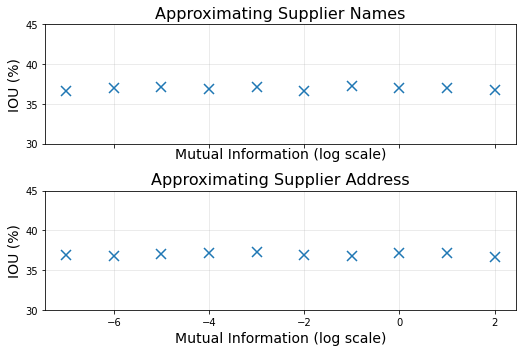

In [121]:
print("Q20")
mis = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]
xs = [np.log2(x) for x in mis]
fig, axes = plt.subplots(2, 1, figsize=(7.5, 5), sharex=True)
for ind, key in enumerate(['s_name', 's_address']):
    names = ["Names", "Address"]
    ax = axes[ind]
    print(agreement[key])
    ax.plot(xs, agreement[key], 'x', markersize=10, mew=1.5,
    )
    print('reached')
    ax.set_xlabel('Mutual Information (log scale)', fontsize=14)
    ax.set_ylabel(f'IOU (%)', fontsize=14)
    ax.set_title(f'Approximating Supplier {names[ind]}', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_ylim((30, 45))
# plt.show()
plt.tight_layout()
plt.savefig('figs/q20_results.png')

In [54]:
np.average(iou)

0.5237777777777778

In [55]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,mi,pct_agreement_s_name,pct_agreement_s_address
u32,str,str,list[str],list[str],f64,f64,f64
0,"""Supplier#000000157""","""1EmkCApL5iF""","[""Supplier#000000378"", ""Supplier#000000378"", … ""Supplier#000000378""]","[""1EmkCApL5iF"", ""mLPJtpu4wOc cSFzBR"", … ""UQR8bUA4V2HxVbw9K""]",4.0,26.0,23.0
1,"""Supplier#000000197""","""3oYqODDUGH3XsHXmPuzYHW5NLU3,ON…","[""Supplier#000000287"", ""Supplier#000000378"", … ""Supplier#000000197""]","[""mLPJtpu4wOc cSFzBR"", ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke"", … ""3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl""]",4.0,19.6,20.7
2,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000287"", ""Supplier#000000378"", … ""Supplier#000000378""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""UQR8bUA4V2HxVbw9K"", … ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""]",4.0,16.916917,15.5
3,"""Supplier#000000378""","""mLPJtpu4wOc cSFzBR""","[""Supplier#000000557"", ""Supplier#000000555"", … ""Supplier#000000378""]","[""mLPJtpu4wOc cSFzBR"", ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", … ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI""]",4.0,17.272727,17.421954
4,"""Supplier#000000530""","""0BvoewCPg2scOEfuL93FRKqSxHmdhw…","[""Supplier#000000555"", ""Supplier#000000935"", … ""Supplier#000000935""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", … ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI""]",4.0,19.499479,21.517672
5,"""Supplier#000000555""","""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""","[""Supplier#000000555"", ""Supplier#000000935"", … ""Supplier#000000935""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""IH,v63JRgXMkVhJOJ Gxur0W"", … ""IH,v63JRgXMkVhJOJ Gxur0W""]",4.0,25.886525,25.752106
6,"""Supplier#000000557""","""IH,v63JRgXMkVhJOJ Gxur0W""","[""Supplier#000000557"", ""Supplier#000000935"", … ""Supplier#000000729""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI""]",4.0,32.258065,29.623568
7,"""Supplier#000000729""","""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHL…",[null],[null],4.0,null,null
8,"""Supplier#000000935""","""JHRSOterYgt4MTNo7cupTzA,6MoNw …",[null],[null],4.0,null,null


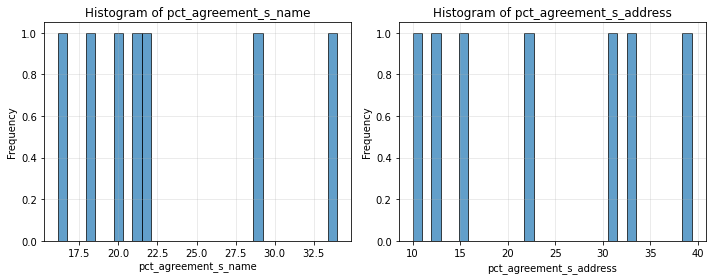

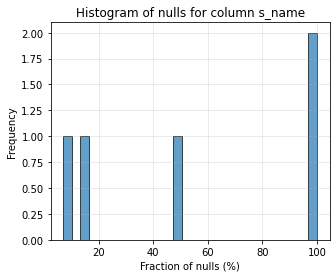

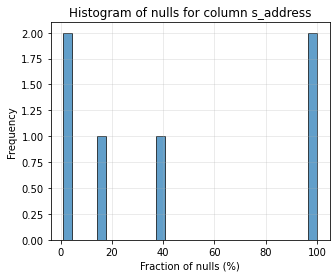

In [65]:

# Get columns that start with 'pct_diff'
pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_agreement')]

# Create subplots based on number of pct_diff columns
n_cols = len(pct_diff_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

# Handle case where there's only one column (axes won't be a list)
if n_cols == 1:
    axes = [axes]

# Create histogram for each column
for i, col in enumerate(pct_diff_cols):
    # Convert to pandas for easier plotting, or use polars plot method
    values = merged_df[col].to_pandas()

    axes[i].hist(values, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'figs/mi_1_2/q{query_ind}_{col}_hist.png', facecolor='white', bbox_inches='tight')

for base in null_info:
    (nulls_exist, null_inds, null_vals) = null_info[base]
    if nulls_exist:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
        axes = [axes]
        axes[0].hist(null_vals, bins=30, alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Histogram of nulls for column {base}')
        axes[0].set_xlabel('Fraction of nulls (%)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)
        plt.savefig(f'figs/mi_1_2/q{query_ind}_{base}_nulls.png', facecolor='white', bbox_inches='tight')